# Testing the PSF response

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import autometacal as amc
import tensorflow_datasets as tfds
import tensorflow as tf
import galflow as gf

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [13]:
batch_size=1000
data= tfds.load('GalGen/small_stamp_1k')
data = data['train'].cache()
data = data.repeat()
data = data.shuffle(1000)
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

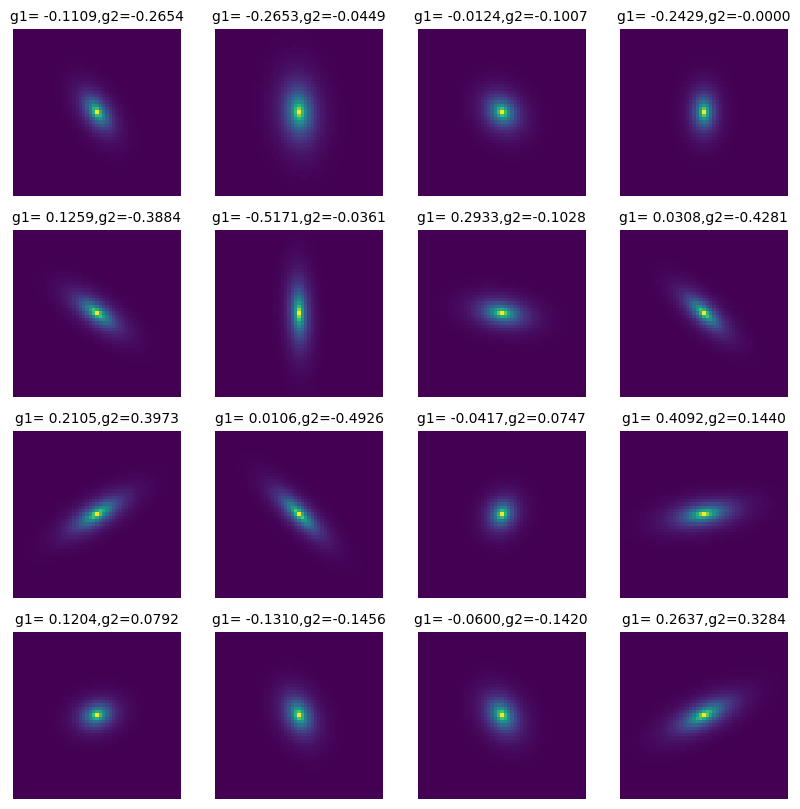

In [20]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
gal_images = onebatch['gal_model'] 
labels = onebatch['label'] 
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i],origin='lower')
  title(f"g1= {labels[i][0]:.4f},g2={labels[i][1]:.4f}",fontsize=10)
  axis('off')

In [24]:
sheared=amc.noiseless_real_mcal_image(onebatch['gal_model'],onebatch['psf_image'],
                          tf.repeat([[0.,0.01]],len(onebatch['gal_model']),axis=0))

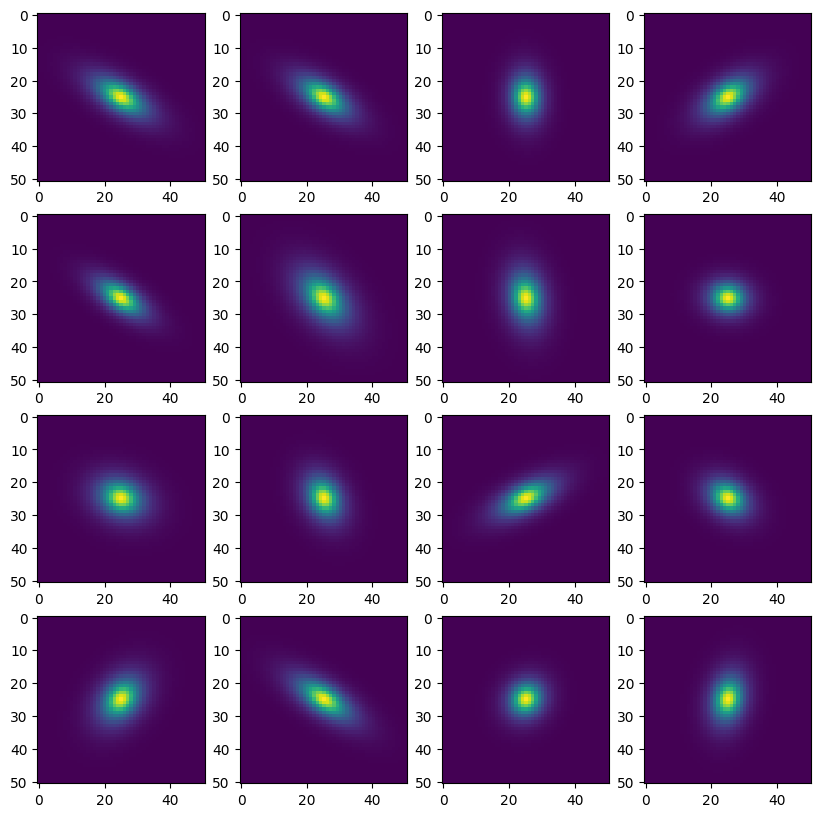

In [25]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(sheared[i])

In [ ]:
dlist = []
dlist_auto = []
dlist_R_auto = []

dlist_finite = []
dlist_R_finite = []

for i in tqdm.tqdm(arange(args['ntrial'])):

    obs = make_data(rng=rng, noise=args['noise'], shear=args['shear_true'])

    resdict, obsdict = boot.go(obs)

    for stype, sres in resdict.items():
        st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
        dlist.append(st)

    # Same thing with autometacal
    im = obs.image.reshape(1,45,45).astype('float32')
    psf = obs.psf.image.reshape(1,45,45).astype('float32') 
    rpsf = obsdict['noshear'].psf.image.reshape(1,45,45).astype('float32') 
    g, R = get_autometacal_shape(im, psf, rpsf)

    g_finite, R_finite =  get_finitediff_shape(im, psf, rpsf)

    dlist_auto.append(g)
    dlist_R_auto.append(R)

    dlist_finite.append(g_finite['noshear'])
    dlist_R_finite.append(R_finite)

In [ ]:
data = np.hstack(dlist)
data_auto = np.vstack(dlist_auto)
data_R_auto = np.vstack(dlist_R_auto)

data_finite = np.vstack(dlist_finite)
data_R_finite = np.vstack(dlist_R_finite)

w = select(data=data, shear_type='noshear')
w_1p = select(data=data, shear_type='1p')
w_1m = select(data=data, shear_type='1m')

g = data['g'][w].mean(axis=0)
auto_g = data_auto.mean(axis=0)
finite_g = data_finite.mean(axis=0)

gerr = data['g'][w].std(axis=0) / np.sqrt(w.size)
auto_gerr = data_auto.std(axis=0) / np.sqrt(w.size)
finite_gerr = data_finite.std(axis=0) / np.sqrt(w.size)

#ngmix
g1_1p = data['g'][w_1p, 0].mean()
g1_1m = data['g'][w_1m, 0].mean()
R11 = (g1_1p - g1_1m)/0.02

#autometacal finite differences
finite_R = data_R_finite.mean(axis=0)

#autometacal 
auto_R = data_R_auto.mean(axis=0)
#ngmix
shear = g / R11
shear_err = gerr / R11
m = shear[0] / args['shear_true'][0]-1
merr = shear_err[0] / args['shear_true'][0]

#autometacal finite differences
finite_shear = finite_g / finite_R[0,0]
finite_shear_err = finite_gerr / finite_R[0,0]
finite_m = finite_shear[0] / args['shear_true'][0] - 1
finite_merr = finite_shear_err[0] / args['shear_true'][0]

#autometacal
auto_shear = auto_g / auto_R[0,0]
auto_shear_err = auto_gerr / auto_R[0,0]
auto_m = auto_shear[0] / args['shear_true'][0]-1
auto_merr = auto_shear_err[0] / args['shear_true'][0]

s2n = data['s2n'][w].mean()